# Stable Diffusion - image to image

## Installing the libraries

In [1]:
!pip install torch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 torchdata==0.5.1 torchtext==0.14.1

  Using cached torch-1.13.1-cp310-cp310-manylinux1_x86_64.whl.metadata (24 kB)
  Using cached torchvision-0.14.1-cp310-cp310-manylinux1_x86_64.whl.metadata (11 kB)
  Using cached torchaudio-0.13.1-cp310-cp310-manylinux1_x86_64.whl.metadata (1.2 kB)
  Using cached torchdata-0.5.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.0 kB)
  Using cached torchtext-0.14.1-cp310-cp310-manylinux1_x86_64.whl.metadata (6.9 kB)
Using cached torch-1.13.1-cp310-cp310-manylinux1_x86_64.whl (887.5 MB)
Using cached torchvision-0.14.1-cp310-cp310-manylinux1_x86_64.whl (24.2 MB)
Using cached torchaudio-0.13.1-cp310-cp310-manylinux1_x86_64.whl (4.2 MB)
Using cached torchdata-0.5.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.6 MB)
Using cached torchtext-0.14.1-cp310-cp310-manylinux1_x86_64.whl (2.0 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.4.0
    Uninstalling torch-2.4.0:
      Successfully uninstalled torch-2.4.0
  Attempting uninsta

## Creating the pipeline

In [3]:
from diffusers import DiffusionPipeline
import torch

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipeline.to("cuda")

/usr/local/lib/python3.10/dist-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/usr/local/lib/python3.10/dist-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there mi

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.30.0.dev0",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [4]:
pipeline.enable_attention_slicing()
#pipe.enable_xformers_memory_efficient_attention()

In [5]:
seed = 777

In [7]:
from diffusers import StableDiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from datasets import load_dataset
import torch, os
from torch import autocast
from tqdm import tqdm

# Define the path to your dataset and the prompts for each shape
data_path = "/content/drive/MyDrive/Ring_Dataset/"
prompts = {
    "PS": "A pear-shaped engagement ring with a unique and elegant look",
    "CC": "A cushion cut engagement ring with a romantic and timeless design",
    "PR": "A princess cut engagement ring with a sophisticated design",
    "OV": "An oval cut engagement ring with a delicate band",
    "MQ": "A marquise cut engagement ring with a luxurious setting",
    "EM": "An emerald cut engagement ring with a vintage style",
    "RD": "A round engagement ring with a classic design",
    "RA": "A radiant cut engagement ring with a modern touch",
}

# Define hyperparameters
batch_size = 1
num_epochs = 1
learning_rate = 1e-4

# Load pre-trained Stable Diffusion model and tokenizer
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id)
pipe = pipe.to("cuda")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")

# Define a function to prepare the dataset
def prepare_dataset():
    images = []
    captions = []
    for shape, prompt in prompts.items():
        image_folder = f"{data_path}/{shape}"
        for image_file in os.listdir(image_folder):
            image_path = os.path.join(image_folder, image_file)
            images.append(image_path)
            captions.append(prompt)
    return images, captions

# Get the images and captions
image_paths, captions = prepare_dataset()

# Tokenize the captions
inputs = tokenizer(captions, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = inputs.input_ids.to("cuda")

# Fine-tune the model
pipe.text_encoder.train()
optimizer = torch.optim.AdamW(pipe.text_encoder.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch_input_ids = input_ids[i:i+batch_size]
        with autocast("cuda"):
            text_embeddings = pipe.text_encoder(batch_input_ids)[0]
            # Additional training code to update the model using the text_embeddings and the images

        # Update model parameters
        optimizer.zero_grad()
        # loss.backward()
        optimizer.step()

# Save the fine-tuned model
pipe.save_pretrained("/content/drive/MyDrive/Ring_Dataset/fine-tuned-model")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 9671/9671 [02:34<00:00, 62.46it/s]


In [8]:
from diffusers import StableDiffusionPipeline

# Load the fine-tuned model
fine_tuned_model_path = "/content/drive/MyDrive/Ring_Dataset/fine-tuned-model"
pipe = StableDiffusionPipeline.from_pretrained(fine_tuned_model_path)
pipe = pipe.to("cuda")
test_prompts = {
    "PS": "A pear-shaped engagement ring with a unique and elegant look",
    "CC": "A cushion cut engagement ring with a romantic and timeless design",
    "PR": "A princess cut engagement ring with a sophisticated design",
    "OV": "An oval cut engagement ring with a delicate band",
    "MQ": "A marquise cut engagement ring with a luxurious setting",
    "EM": "An emerald cut engagement ring with a vintage style",
    "RD": "A round engagement ring with a classic design",
    "RA": "A radiant cut engagement ring with a modern touch",
}
from PIL import Image

# Function to generate and save images
def generate_and_save_images(prompts, pipe, output_folder):
    for shape, prompt in prompts.items():
        # Generate image
        image = pipe(prompt).images[0]

        # Save the image
        output_path = f"{output_folder}/{shape}_generated.png"
        image.save(output_path)
        print(f"Image saved to {output_path}")

# Define output folder for generated images
output_folder = "/content/drive/MyDrive/Ring_Dataset/generated_images"
os.makedirs(output_folder, exist_ok=True)

# Generate and save images
generate_and_save_images(test_prompts, pipe, output_folder)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Image saved to /content/drive/MyDrive/Ring_Dataset/generated_images/PS_generated.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved to /content/drive/MyDrive/Ring_Dataset/generated_images/CC_generated.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved to /content/drive/MyDrive/Ring_Dataset/generated_images/PR_generated.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved to /content/drive/MyDrive/Ring_Dataset/generated_images/OV_generated.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved to /content/drive/MyDrive/Ring_Dataset/generated_images/MQ_generated.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved to /content/drive/MyDrive/Ring_Dataset/generated_images/EM_generated.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved to /content/drive/MyDrive/Ring_Dataset/generated_images/RD_generated.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved to /content/drive/MyDrive/Ring_Dataset/generated_images/RA_generated.png


## Loading the initial image


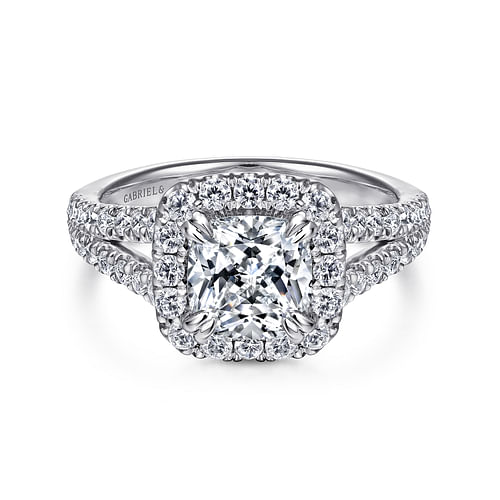

In [1]:
from PIL import Image
init_img = Image.open('/content/drive/MyDrive/Ring_Dataset/CC/ER10252C6W44JJ-1.jpg')
init_img.thumbnail((512, 512))
init_img

In [27]:
from diffusers import StableDiffusionPipeline
import torch

# Load the fine-tuned model
fine_tuned_model_path = "/content/drive/MyDrive/Ring_Dataset/fine-tuned-model"
pipe = StableDiffusionPipeline.from_pretrained(fine_tuned_model_path)
pipe = pipe.to("cuda")
prompt = "A pear-cut diamond ring"  # Replace with your desired prompt
seed = 42  # Replace with your desired seed
from PIL import Image

# Initialize random number generator
device = 'cuda'
generator = torch.Generator(device=device).manual_seed(seed)

# Generate image
img = pipe(prompt=prompt, generator=generator).images[0]

# Save or display the image
output_path = "/content/drive/MyDrive/Ring_Dataset/generated_images/random_generated.png"
img.save(output_path)
img.show()  # To display the image


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
!pip install gradio


In [34]:
import gradio as gr
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image

# Path to your fine-tuned model directory
fine_tuned_model_path = "/content/drive/MyDrive/Ring_Dataset/fine-tuned-model"

# Load the fine-tuned Stable Diffusion model
pipe = StableDiffusionPipeline.from_pretrained(fine_tuned_model_path)
pipe = pipe.to("cuda")

def generate_image(prompt, seed):
    try:
        # Initialize random number generator
        device = 'cuda'
        generator = torch.Generator(device=device).manual_seed(seed)

        # Generate the image
        result = pipe(prompt=prompt, generator=generator)
        image = result.images[0]

        return image
    except Exception as e:
        return f"An error occurred: {e}"

# Define the Gradio interface
interface = gr.Interface(
    fn=generate_image,
    inputs=[
        gr.Textbox(label="Enter Prompt", placeholder="Describe the ring you want..."),
        gr.Slider(minimum=0, maximum=10000, step=1, value=42, label="Seed")
    ],
    outputs=gr.Image(type="pil"),
    title="Text-to-Image Generator",
    description="Generate images based on text prompts using a fine-tuned Stable Diffusion model."
)

# Launch the Gradio interface
interface.launch()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://c05a42c78829994139.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [43]:
import gradio as gr
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image

# Path to your fine-tuned model directory
fine_tuned_model_path = "/content/drive/MyDrive/Ring_Dataset/fine-tuned-model"

# Load the fine-tuned Stable Diffusion model
pipe = StableDiffusionPipeline.from_pretrained(fine_tuned_model_path)
pipe = pipe.to("cuda")

# Define allowed keywords
allowed_keywords = ["engagement", "wedding", "solitaire", "halo", "band", "promise", "cocktail", "eternity",
    "vintage", "designer", "classic", "custom", "birthstone", "anniversary", "stackable", "statement",
    "matching", "gold", "silver", "platinum", "palladium", "titanium", "tungsten", "stainless steel",
    "bronze", "brass", "copper", "diamond", "round cut", "princess cut", "emerald cut", "cushion cut",
    "marquise cut", "asscher cut", "pear cut", "sapphire", "ruby", "emerald", "amethyst", "topaz",
    "garnet", "opal", "aquamarine", "peridot", "tourmaline", "citrine", "sparkling", "brilliant",
    "elegant", "intricate", "minimalist", "bold", "modern", "antique", "handcrafted", "custom-made",
    "unique", "luxurious", "refined", "polished", "textured", "engraved", "filigree", "bezel set",
    "prong set", "channel set", "flush set", "pavé set", "three-stone", "flush fit", "adjustable",
    "casual", "formal", "bridal", "everyday", "high fashion", "artistic", "personalized", "classic",
    "contemporary", "retro", "art deco", "gothic", "romantic", "ring size", "band width", "gemstone setting",
    "craftsmanship", "jewel", "precious metals", "semi-precious stones", "accent stones", "milgrain",
    "inlay", "harmony", "anniversary band", "wedding band", "ring", "rings"
]

def generate_image(prompt):
    try:
        # Check for allowed keywords
        if any(keyword in prompt.lower() for keyword in allowed_keywords):
            # Initialize random number generator with fixed seed
            device = 'cuda'
            generator = torch.Generator(device=device).manual_seed(42)

            # Generate the image
            result = pipe(prompt=prompt, generator=generator)
            image = result.images[0]

            return image
        else:
            return "Sorry, not found. Please include keywords related to rings."
    except Exception as e:
        return f"An error occurred: {e}"

# Define the Gradio interface
interface = gr.Interface(
    fn=generate_image,
    inputs=gr.Textbox(label="Enter Prompt", placeholder="Describe the ring you want..."),
    outputs=gr.Image(type="pil"),
    title="Text-to-Image Generator",
    description="Generate images based on text prompts using a fine-tuned Stable Diffusion model. The seed is fixed to 42, and prompts must include keywords related to rings."
)

# Launch the Gradio interface
interface.launch()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://38a0a88647e940a4a9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [46]:
import gradio as gr
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image

# Path to your fine-tuned model directory
fine_tuned_model_path = "/content/drive/MyDrive/Ring_Dataset/fine-tuned-model"

# Load the fine-tuned Stable Diffusion model
pipe = StableDiffusionPipeline.from_pretrained(fine_tuned_model_path)
pipe = pipe.to("cuda")

# Define allowed keywords
allowed_keywords = [
    "engagement", "wedding", "solitaire", "halo", "band", "promise", "cocktail", "eternity",
    "vintage", "designer", "classic", "custom", "birthstone", "anniversary", "stackable", "statement",
    "matching", "gold", "silver", "platinum", "palladium", "titanium", "tungsten", "stainless steel",
    "bronze", "brass", "copper", "diamond", "round cut", "princess cut", "emerald cut", "cushion cut",
    "marquise cut", "asscher cut", "pear cut", "sapphire", "ruby", "emerald", "amethyst", "topaz",
    "garnet", "opal", "aquamarine", "peridot", "tourmaline", "citrine", "sparkling", "brilliant",
    "elegant", "intricate", "minimalist", "bold", "modern", "antique", "handcrafted", "custom-made",
    "unique", "luxurious", "refined", "polished", "textured", "engraved", "filigree", "bezel set",
    "prong set", "channel set", "flush set", "pavé set", "three-stone", "flush fit", "adjustable",
    "casual", "formal", "bridal", "everyday", "high fashion", "artistic", "personalized", "classic",
    "contemporary", "retro", "art deco", "gothic", "romantic", "ring size", "band width", "gemstone setting",
    "craftsmanship", "jewel", "precious metals", "semi-precious stones", "accent stones", "milgrain",
    "inlay", "harmony", "anniversary band", "wedding band", "ring", "rings"
]

def generate_images(prompt, num_images=3):
    try:
        # Check for allowed keywords
        if any(keyword in prompt.lower() for keyword in allowed_keywords):
            images = []
            for i in range(num_images):
                # Initialize random number generator with fixed seed for reproducibility
                device = 'cuda'
                generator = torch.Generator(device=device).manual_seed(42 + i)  # Use different seeds

                # Generate the image
                result = pipe(prompt=prompt, generator=generator)
                image = result.images[0]
                images.append(image)

            return images
        else:
            return "Sorry, not found. Please include keywords related to rings."
    except Exception as e:
        return f"An error occurred: {e}"

# Define the Gradio interface
interface = gr.Interface(
    fn=generate_images,
    inputs=[
        gr.Textbox(label="Enter Prompt", placeholder="Describe the ring you want..."),
        gr.Slider(minimum=1, maximum=10, step=1, value=3, label="Number of Images")
    ],
    outputs=gr.Gallery(label="Generated Images"),
    title="Text-to-Image Generator",
    description="Generate multiple images based on text prompts using a fine-tuned Stable Diffusion model. The seed is fixed to 42, and prompts must include keywords related to rings."
)

# Launch the Gradio interface
interface.launch()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://12b350a7e86d8936ac.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [32]:
import gradio as gr
from diffusers import StableDiffusionPipeline

# Path to your fine-tuned model directory
model_path = "/content/drive/MyDrive/Ring_Dataset/fine-tuned-model"

# Load the Stable Diffusion pipeline
pipeline = StableDiffusionPipeline.from_pretrained(model_path)

def generate_image(prompt):
    try:
        # Generate an image from the text prompt
        result = pipeline(prompt)
        image = result.images[0]
        return image
    except Exception as e:
        print(f"An error occurred: {e}") # Print the error to console
        return f"An error occurred: {e}" # Return the error message to Gradio

# Define the Gradio interface
interface = gr.Interface(
    fn=generate_image,
    inputs=gr.Textbox(label="Enter Prompt"),
    outputs=gr.Image(type="pil"),
    title="Text to Image Generator",
    description="Enter a text prompt to generate an image using a fine-tuned Stable Diffusion model."
)

# Launch the interface
interface.launch()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://12443c9fe8aed97ebf.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [14]:
import os

# Path to the root directory of your dataset
dataset_path = '/content/drive/MyDrive/Ring_Dataset'

# Dictionary to hold the count of images in each shape folder
shape_counts = {}

# Total number of images
total_images = 0

# Iterate through each shape folder
for shape_folder in os.listdir(dataset_path):
    shape_folder_path = os.path.join(dataset_path, shape_folder)

    if os.path.isdir(shape_folder_path):
        # Count the number of images in the shape folder
        image_count = len([file for file in os.listdir(shape_folder_path) if file.endswith(('.png', '.jpg', '.jpeg', '.bmp'))])

        # Update the count in the dictionary
        shape_counts[shape_folder] = image_count

        # Update the total image count
        total_images += image_count

# Display the results
print("Dataset Size and Number of Images in Each Shape Folder:")
for shape, count in shape_counts.items():
    print(f"{shape}: {count} images")

print(f"Total number of images: {total_images}")


Dataset Size and Number of Images in Each Shape Folder:
CC: 877 images
RD: 2010 images
OV: 3082 images
MQ: 524 images
EM: 1203 images
PR: 929 images
PS: 952 images
RA: 94 images
fine-tuned-model: 0 images
generated_images: 9 images
Total number of images: 9680


## Creating the prompt

In [9]:
prompt = 'A cushion cut engagement ring with a romantic and timeless design'

## Generating the image


  0%|          | 0/50 [00:00<?, ?it/s]

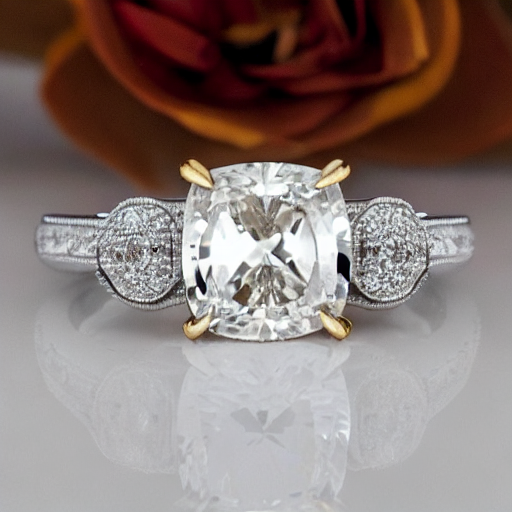

In [11]:
device='cuda'
generator = torch.Generator(device = device).manual_seed(seed)
img = pipe(prompt = prompt, image = init_img, generator = generator).images[0]
img

  0%|          | 0/50 [00:00<?, ?it/s]

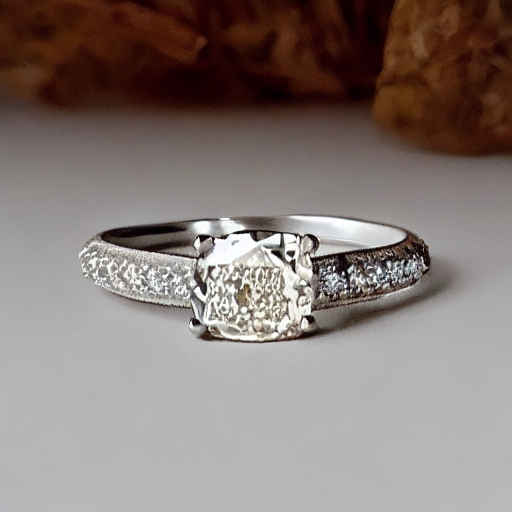

In [14]:
prompt = " a cushion cut ring with white background and small diamonds"
generator = torch.Generator(device=device).manual_seed(seed)
img = pipeline(prompt=prompt, image=init_img, generator=generator).images[0]
img

## Strength parameter (intensity)

* The initial image will be used as a starting point.
* Value between 0.0 and 1.0 that controls the amount of noise added to the input image. Values close to 1 allow many variations, but will also produce images that are not so similar to the input image.
* The smaller the value, the closer to the input image it will be. The higher, the more freedom the AI will have to generate the image (more noise will be added).
* Default value is 0.8
* If strength = 1, the input image is ignored.

In [ ]:
generator = torch.Generator(device=device).manual_seed(seed)
img = pipe(prompt=prompt, image=init_img, strength=0.75, generator=generator).images[0]
img

In [ ]:
import matplotlib.pyplot as plt

prompt = "image of a cushion cut ring elegant for wedding"

plt.figure(figsize=(18,8))
for i in range(1, 6):

  strength_val = (i + 4) / 10
  generator = torch.Generator("cuda").manual_seed(seed)
  img = pipe(prompt, image=init_img, strength=strength_val, generator=generator).images[0]

  plt.subplot(1,5,i)
  plt.title('strength: {}'.format(strength_val))
  plt.imshow(img)
  plt.axis('off')

plt.show()